In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zlatan599/garbage-dataset-classification")

print("Path to dataset files:", path)

path = os.path.join(path,'Garbage_Dataset_Classification' ,'images')

Using Colab cache for faster access to the 'garbage-dataset-classification' dataset.
Path to dataset files: /kaggle/input/garbage-dataset-classification


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
DROP_OUT = 0.4
EPOCHS = 10
LEARNING_RATE = 0.0001
NUM_CLASSES = 6
FINE_TUNE_LEARNING_RATE = 0.00001


In [ ]:
def load_data():
    full_dataset = tf.keras.utils.image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='int',
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        shuffle=True,  # Randomly shuffles all images
        seed=123,      # Makes shuffle reproducible
    )

    total_size = tf.data.experimental.cardinality(full_dataset).numpy()
    train_size = int(0.8 * total_size)  # 80% of batches
    val_size = int(0.1 * total_size)    # 10% of batches

    train_dataset = full_dataset.take(train_size)     # First 80% of batches
    remaining = full_dataset.skip(train_size)         # Skip first 80%, get last 20%
    val_dataset = remaining.take(val_size)            # First 10% of remaining (so 10% of total)
    test_dataset = remaining.skip(val_size)           # Skip the validation part, get final 10%


    return train_dataset, val_dataset, test_dataset



In [ ]:
def noramalize(train,val,test):
    normalization_layer = layers.Rescaling(1./255)
    train = train.map(lambda x, y: (normalization_layer(x), y))
    val = val.map(lambda x, y: (normalization_layer(x), y))
    test = test.map(lambda x, y: (normalization_layer(x), y))

    AUTOTUNE = tf.data.AUTOTUNE

    train = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val = val.cache().prefetch(buffer_size=AUTOTUNE)
    test = test.cache().prefetch(buffer_size=AUTOTUNE)
    return train,val,test

In [ ]:
train_orig,val_orig,test_orig = load_data()
train,val,test = noramalize(train_orig,val_orig,test_orig)
NUM_CLASSES = 6


Found 13901 files belonging to 6 classes.


In [31]:
def check_class_distribution(dataset, dataset_name, num_batches=None):
    """Check class distribution in a tf.data.Dataset"""
    all_labels = []
    batch_count = 0

    # If num_batches is None, check all batches (might be slow)
    dataset_to_check = dataset.take(num_batches) if num_batches else dataset

    for images, labels in dataset_to_check:
        # Handle both single labels and batch of labels
        if len(labels.shape) == 0:  # Single label (batch_size=1)
            all_labels.append(labels.numpy())
        else:  # Batch of labels
            all_labels.extend(labels.numpy())
        batch_count += 1

    # Count each class
    unique_labels, counts = np.unique(all_labels, return_counts=True)
    total_samples = len(all_labels)

    print(f"\n{dataset_name} Distribution:")
    print(f"Total samples checked: {total_samples} (from {batch_count} batches)")
    print("-" * 40)

    for label, count in zip(unique_labels, counts):
        percentage = (count / total_samples) * 100
        print(f"Class {label}: {count:4d} samples ({percentage:5.1f}%)")

    return dict(zip(unique_labels, counts))

# Usage:
train_dist = check_class_distribution(train, "Training", num_batches=100)
val_dist = check_class_distribution(val, "Validation")
test_dist = check_class_distribution(test, "Test")


Training Distribution:
Total samples checked: 3200 (from 100 batches)
----------------------------------------
Class 0:  506 samples ( 15.8%)
Class 1:  572 samples ( 17.9%)
Class 2:  490 samples ( 15.3%)
Class 3:  529 samples ( 16.5%)
Class 4:  547 samples ( 17.1%)
Class 5:  556 samples ( 17.4%)

Validation Distribution:
Total samples checked: 1376 (from 43 batches)
----------------------------------------
Class 0:  213 samples ( 15.5%)
Class 1:  249 samples ( 18.1%)
Class 2:  202 samples ( 14.7%)
Class 3:  230 samples ( 16.7%)
Class 4:  233 samples ( 16.9%)
Class 5:  249 samples ( 18.1%)

Test Distribution:
Total samples checked: 1389 (from 44 batches)
----------------------------------------
Class 0:  218 samples ( 15.7%)
Class 1:  275 samples ( 19.8%)
Class 2:  200 samples ( 14.4%)
Class 3:  227 samples ( 16.3%)
Class 4:  217 samples ( 15.6%)
Class 5:  252 samples ( 18.1%)


In [ ]:
for image_batch, labels_batch in train:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


In [ ]:
for images, labels in train_orig.take(5):
    print(f"Test batch labels: {labels.numpy()}")

Test batch labels: [4 0 5 1 0 5 5 5 1 1 0 2 4 1 1 0 3 0 1 3 0 2 5 0 0 0 3 5 5 2 1 5]
Test batch labels: [3 4 2 5 1 3 0 5 3 4 5 1 0 5 4 5 4 3 2 1 3 0 1 1 4 5 5 2 0 2 2 1]
Test batch labels: [1 4 2 0 1 3 5 1 1 5 3 5 5 2 1 2 0 0 1 4 2 3 4 3 3 0 0 0 2 1 2 2]
Test batch labels: [2 5 4 5 0 5 4 3 0 0 4 0 3 2 5 0 2 2 0 1 1 1 4 3 2 5 3 5 0 4 5 5]
Test batch labels: [1 4 4 0 4 0 0 3 0 5 2 1 5 0 5 0 5 2 0 5 0 2 5 1 5 2 2 0 2 5 3 5]


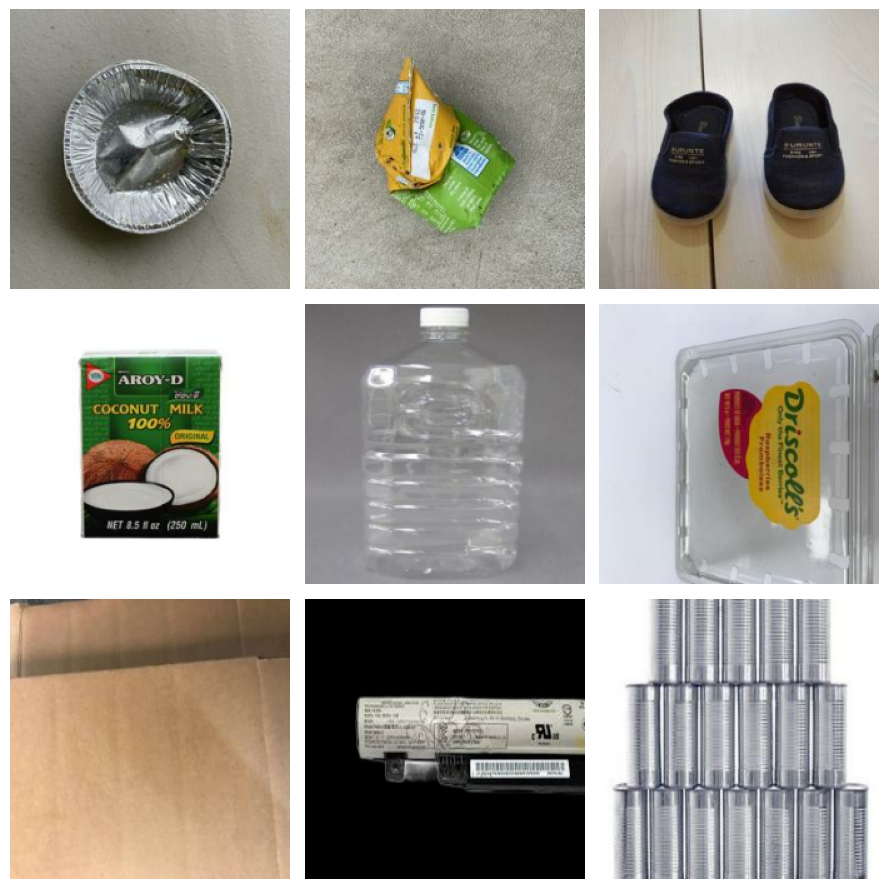

In [ ]:
index = 13
example = train_orig.unbatch().take(1).as_numpy_iterator().next()

exaples = train_orig.unbatch().take(9).as_numpy_iterator()

plt.figure(figsize=(9, 9))

for i, (image, label) in enumerate(exaples):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image.astype("uint8"))
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
def data_augmentor():

    data_aug = keras.models.Sequential()
    data_aug.add(layers.RandomFlip("horizontal_and_vertical"))
    data_aug.add(layers.RandomRotation(0.2))

    return data_aug

In [ ]:
def model(augmentation_layer=data_augmentor()):
    IMG_SHAPE = IMG_SIZE + (3,)

    preprocess_input = keras.applications.mobilenet_v2.preprocess_input

    base_model = keras.applications.MobileNetV2(
        input_shape=IMG_SHAPE,
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    inputs = keras.Input(shape=IMG_SHAPE)

    #x = augmentation_layer(inputs)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(DROP_OUT)(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    return model


In [ ]:
train_model = model()

model = model()  # Create your model
print(model.summary())

# Check the last layer specifically:
print(f"Output layer units: {model.layers[-1].units}")
print(f"NUM_CLASSES setting: {NUM_CLASSES}")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None
Output layer units: 6
NUM_CLASSES setting: 6


In [ ]:
if os.path.exists('./models/best_garbage.weights.h5'):
    train_model.load_weights('./models/best_garbage.weights.h5')
else:
    train_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='./models/best_garbage.weights.h5',
    monitor='val_accuracy',  # or 'val_loss'
    save_best_only=True,
    save_weights_only=True,  # saves entire model
    mode='max',  # 'max' for accuracy, 'min' for loss
    verbose=1
)



history = train_model.fit(
    train,
    epochs=2,
    validation_data=val,
    callbacks=[checkpoint_callback]
)

Epoch 1/2
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9503 - loss: 0.1969
Epoch 1: val_accuracy improved from -inf to 0.83285, saving model to ./models/best_garbage(0.95).weights.h5
348/348 ━━━━━━━━━━━━━━━━━━━━ 25s 73ms/step - accuracy: 0.9504 - loss: 0.1967 - val_accuracy: 0.8328 - val_loss: 1.1846
Epoch 2/2
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9919 - loss: 0.0284
Epoch 2: val_accuracy improved from 0.83285 to 0.93241, saving model to ./models/best_garbage(0.95).weights.h5
348/348 ━━━━━━━━━━━━━━━━━━━━ 41s 73ms/step - accuracy: 0.9919 - loss: 0.0284 - val_accuracy: 0.9324 - val_loss: 0.4343


In [ ]:

tune_model = train_model.layers[1]
tune_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 20

# Freeze all layers before the `fine_tune_at` layer
for layer in tune_model.layers[:fine_tune_at]:
    layer.trainable = False

tune_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=FINE_TUNE_LEARNING_RATE),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

if os.path.exists('./models/best_garbage.weights.h5'):
    train_model.load_weights('./models/best_garbage.weights.h5')

with tf.device('/GPU:0'):
    fine_tune_history = train_model.fit(
        train,
        epochs=EPOCHS,
        validation_data=val,
        callbacks=[checkpoint_callback]
    )

train_model.save('./models/best_garbage.keras')



Epoch 1/10
347/348 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7936 - loss: 0.5724
Epoch 1: val_accuracy improved from 0.81250 to 0.83721, saving model to ./models/best_garbage.weights.h5
348/348 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.7937 - loss: 0.5724 - val_accuracy: 0.8372 - val_loss: 0.4711
Epoch 2/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8129 - loss: 0.5101
Epoch 2: val_accuracy improved from 0.83721 to 0.84811, saving model to ./models/best_garbage.weights.h5
348/348 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.8129 - loss: 0.5101 - val_accuracy: 0.8481 - val_loss: 0.4394
Epoch 3/10
347/348 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8265 - loss: 0.4809
Epoch 3: val_accuracy improved from 0.84811 to 0.85828, saving model to ./models/best_garbage.weights.h5
348/348 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.8265 - loss: 0.4809 - val_accuracy: 0.8583 - val_loss: 0.4189
Epoch 4/10
346/348 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [30]:
# Evaluate the model on the test dataset

if os.path.exists('./models/best_garbage(0.95).weights.h5'):
    train_model.load_weights('./models/best_garbage(0.95).weights.h5')

test_loss, test_accuracy = train_model.evaluate(test)
print(f'Test accuracy: {test_accuracy:.4f}, Test loss: {test_loss:.4f}')
# -*- coding: utf-8 -*-

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9506 - loss: 0.2897
Test accuracy: 0.9518, Test loss: 0.3120
